In [103]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

In [42]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models, optimizers, losses
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint
from tensorflow.keras.metrics import Precision, Recall
import tensorflow as tf
tf.random.set_seed(
    42
)


import seaborn as sns

tf_chkpt_path = 'tf_checkpoints/'

In [ ]:
# import tensorflow as tf
# tf.config.list_physical_devices()

In [18]:
def display_mode_trainTestGraphs(results):
    train_loss = results.history['loss']
    train_acc = results.history['accuracy']    
#     train_prec = results.history['precision']
#     train_recall = results.history['recall']
    
    val_loss = results.history['val_loss']
    val_acc = results.history['val_accuracy']
#     val_prec = results.history['val_precision']
#     val_recall = results.history['val_recall']

    fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(10, 5))
    
    sns.lineplot(x=results.epoch, y=train_loss, ax=ax1, label='train_loss')
    sns.lineplot(x=results.epoch, y=train_acc, ax=ax2, label='train_accuracy')
#     sns.lineplot(x=results.epoch, y=train_prec, ax=ax3, label='train_precision')
#     sns.lineplot(x=results.epoch, y=train_recall, ax=ax4, label='train_recall')

    sns.lineplot(x=results.epoch, y=val_loss, ax=ax1, label='val_loss')
    sns.lineplot(x=results.epoch, y=val_acc, ax=ax2, label='val_accuracy')
#     sns.lineplot(x=results.epoch, y=val_prec, ax=ax3, label='val_precision')
#     sns.lineplot(x=results.epoch, y=val_recall, ax=ax4, label='val_recall')
    
    ax1.set_title('Loss')
    ax2.set_title('Accuracy')
#     ax3.set_title('Precision')
#     ax4.set_title('Recall')
    ax1.legend();

# Training Set

In [4]:
# Normalizing data for 8 bit
train_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    'images/train/',
    target_size = (227,227),
    batch_size=128,
    color_mode='grayscale',
    class_mode='categorical'
)

Found 48979 images belonging to 8 classes.


# Validation Set

In [5]:
# Normalizing data for 8 bit
val_datagen = ImageDataGenerator(rescale=1./255)

val_generator = val_datagen.flow_from_directory(
    'images/val/',
    target_size = (227,227),
    batch_size=128,
    color_mode='grayscale',
    class_mode='categorical'
)

Found 14175 images belonging to 8 classes.


# Test Set

In [6]:
# Normalizing data for 8 bit
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    'images/test/',
    target_size = (227,227),
    batch_size=128,
    color_mode='grayscale',
    class_mode='categorical'
)

Found 1793 images belonging to 8 classes.


# Modeling

In [7]:
early_stop = EarlyStopping(monitor='val_loss', 
                           min_delta=1e-8,
                           verbose=1,
                           patience = 5,
                           restore_best_weights=True,
                           mode='min')

## Model 1 - Simple CNN

In [8]:
model = models.Sequential()

model.add(layers.Conv2D(filters=32,
                       kernel_size=3,
                       activation='relu',
                       input_shape=(227,227,1)))
model.add(layers.MaxPooling2D(2,2))

model.add(layers.Flatten())
model.add(layers.Dense(8, activation='softmax'))


model.compile(optimizer=optimizers.Adam(learning_rate=0.001),
              loss=losses.CategoricalCrossentropy(),
              metrics=['accuracy', Precision(), Recall()])


model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 225, 225, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 32)     0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 401408)            0         
                                                                 
 dense (Dense)               (None, 8)                 3211272   
                                                                 
Total params: 3,211,592
Trainable params: 3,211,592
Non-trainable params: 0
_________________________________________________________________


In [9]:
results = model.fit(train_generator,
                    callbacks=[early_stop,check],
                    epochs=50,  # Number of epochs
                    validation_data=val_generator,
                    verbose=1
                    )

Epoch 1/50
383/383 [==============================] - 40s 96ms/step - loss: 0.9527 - accuracy: 0.8122 - precision: 0.8173 - recall: 0.7975 - val_loss: 0.8167 - val_accuracy: 0.7934 - val_precision: 0.7977 - val_recall: 0.7824
Epoch 2/50
383/383 [==============================] - 36s 93ms/step - loss: 0.5964 - accuracy: 0.8300 - precision: 0.8402 - recall: 0.8188 - val_loss: 0.7967 - val_accuracy: 0.7940 - val_precision: 0.7994 - val_recall: 0.7879
Epoch 3/50
383/383 [==============================] - 36s 94ms/step - loss: 0.4931 - accuracy: 0.8505 - precision: 0.8613 - recall: 0.8383 - val_loss: 0.7628 - val_accuracy: 0.7944 - val_precision: 0.8017 - val_recall: 0.7861
Epoch 4/50
383/383 [==============================] - 36s 94ms/step - loss: 0.4032 - accuracy: 0.8750 - precision: 0.8848 - recall: 0.8636 - val_loss: 0.8316 - val_accuracy: 0.7934 - val_precision: 0.8019 - val_recall: 0.7805
Epoch 5/50
383/383 [==============================] - 37s 97ms/step - loss: 0.3267 - accuracy: 0

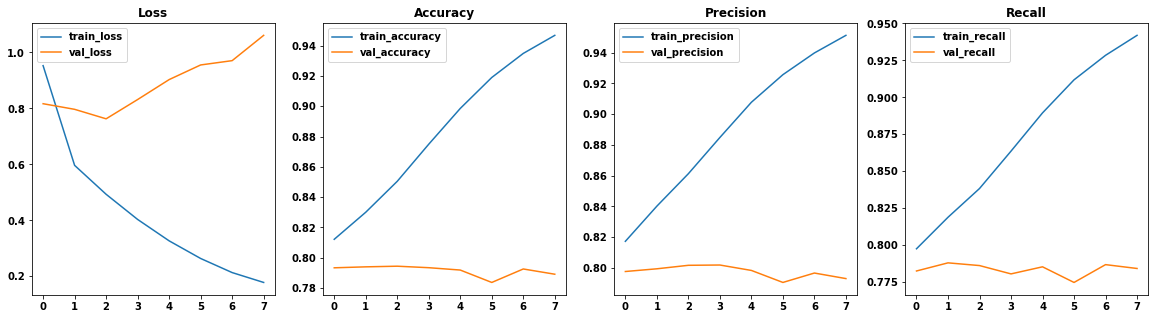

In [13]:
display_mode_trainTestGraphs(results)

Validation loss from the very beginning never improved and overall accuracy went down

## Model 2

In [15]:
model = models.Sequential()

model.add(layers.Conv2D(filters=32,
                       kernel_size=3,
                       activation='relu',
                       input_shape=(227,227,1)))
model.add(layers.MaxPooling2D(2,2))

model.add(layers.Conv2D(32, 3, activation='relu'))
model.add(layers.MaxPooling2D(2,2))

model.add(layers.Conv2D(64, 3, activation='relu'))
model.add(layers.MaxPooling2D(2,2))

model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(8, activation='softmax'))


model.compile(optimizer=optimizers.Adam(learning_rate=0.001),
              loss=losses.CategoricalCrossentropy(),
              metrics=['accuracy', Precision(), Recall()])


model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 225, 225, 32)      320       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 112, 112, 32)     0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 110, 110, 32)      9248      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 55, 55, 32)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 53, 53, 64)        18496     
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 26, 26, 64)      

In [38]:
results = model.fit(train_generator,
                    callbacks=early_stop,
                    steps_per_epoch=100,  # Number of training samples to pull per epoch
                    epochs=50,  # Number of epochs
                    validation_data=val_generator,
                    validation_steps=50,  # Number of validation samples to run validation on
                    verbose=1
                    )

Epoch 1/50
100/100 [==============================] - 13s 123ms/step - loss: 0.3006 - accuracy: 0.9073 - precision_2: 0.9167 - recall_2: 0.8964 - val_loss: 0.7569 - val_accuracy: 0.8053 - val_precision_2: 0.8094 - val_recall_2: 0.8011
Epoch 2/50
100/100 [==============================] - 12s 121ms/step - loss: 0.2989 - accuracy: 0.9052 - precision_2: 0.9143 - recall_2: 0.8963 - val_loss: 0.7328 - val_accuracy: 0.8034 - val_precision_2: 0.8126 - val_recall_2: 0.7914
Epoch 3/50
100/100 [==============================] - 12s 120ms/step - loss: 0.2629 - accuracy: 0.9167 - precision_2: 0.9231 - recall_2: 0.9087 - val_loss: 0.7263 - val_accuracy: 0.8177 - val_precision_2: 0.8229 - val_recall_2: 0.8139
Epoch 4/50
100/100 [==============================] - 12s 120ms/step - loss: 0.2266 - accuracy: 0.9262 - precision_2: 0.9338 - recall_2: 0.9195 - val_loss: 0.6898 - val_accuracy: 0.8195 - val_precision_2: 0.8335 - val_recall_2: 0.8080
Epoch 5/50
100/100 [==============================] - 12s 12

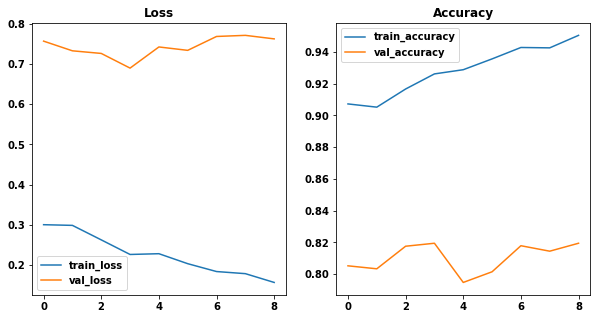

In [39]:
display_mode_trainTestGraphs(results)

In [45]:
results.model.save(tf_chkpt_path+'Model_2')

INFO:tensorflow:Assets written to: tf_checkpoints/Model_2\assets


INFO:tensorflow:Assets written to: tf_checkpoints/Model_2\assets


Started overfitting really early

## Model 3

Adding additional dense layers at end

In [46]:
model = models.Sequential()

model.add(layers.Conv2D(filters=16,
                       kernel_size=3,
                       activation='relu',
                       input_shape=(227,227,1)))
model.add(layers.MaxPooling2D(2,2))

model.add(layers.Conv2D(32, 3, activation='relu'))
model.add(layers.MaxPooling2D(2,2))

model.add(layers.Conv2D(64, 3, activation='relu'))
model.add(layers.MaxPooling2D(2,2))

model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(8, activation='softmax'))


model.compile(optimizer=optimizers.Adam(learning_rate=0.001),
              loss=losses.CategoricalCrossentropy(),
              metrics=['accuracy', Precision(), Recall()])


model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_7 (Conv2D)           (None, 225, 225, 16)      160       
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 112, 112, 16)     0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 110, 110, 32)      4640      
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 55, 55, 32)       0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 53, 53, 64)        18496     
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 26, 26, 64)      

In [47]:
results = model.fit(train_generator,
                    callbacks=early_stop,
                    steps_per_epoch=100,  # Number of training samples to pull per epoch
                    epochs=50,  # Number of epochs
                    validation_data=val_generator,
                    validation_steps=50,  # Number of validation samples to run validation on
                    verbose=1
                    )

Epoch 1/50
100/100 [==============================] - 12s 113ms/step - loss: 0.7770 - accuracy: 0.8110 - precision_3: 0.8206 - recall_3: 0.8009 - val_loss: 0.8230 - val_accuracy: 0.7961 - val_precision_3: 0.8066 - val_recall_3: 0.7675
Epoch 2/50
100/100 [==============================] - 11s 112ms/step - loss: 0.6268 - accuracy: 0.8300 - precision_3: 0.8446 - recall_3: 0.8160 - val_loss: 0.8255 - val_accuracy: 0.7817 - val_precision_3: 0.7963 - val_recall_3: 0.7561
Epoch 3/50
100/100 [==============================] - 11s 112ms/step - loss: 0.5572 - accuracy: 0.8422 - precision_3: 0.8584 - recall_3: 0.8233 - val_loss: 0.7474 - val_accuracy: 0.7977 - val_precision_3: 0.8094 - val_recall_3: 0.7864
Epoch 4/50
100/100 [==============================] - 11s 111ms/step - loss: 0.4990 - accuracy: 0.8555 - precision_3: 0.8728 - recall_3: 0.8394 - val_loss: 0.7802 - val_accuracy: 0.7989 - val_precision_3: 0.8087 - val_recall_3: 0.7802
Epoch 5/50
100/100 [==============================] - 11s 11

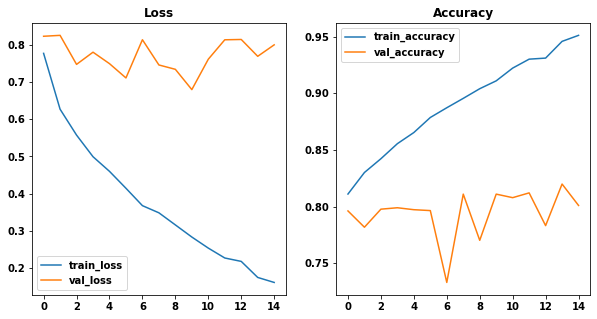

In [48]:
display_mode_trainTestGraphs(results)

In [49]:
results.model.save(tf_chkpt_path+'Model_3')

INFO:tensorflow:Assets written to: tf_checkpoints/Model_3\assets


INFO:tensorflow:Assets written to: tf_checkpoints/Model_3\assets


No appreciable reduction in loss

## Model 4: DNN

Adding an extra layer of conv+maxpooling

In [50]:
model = models.Sequential()

model.add(layers.Conv2D(filters=16,
                       kernel_size=3,
                       activation='relu',
                       input_shape=(227,227,1)))
model.add(layers.MaxPooling2D(2,2))

model.add(layers.Conv2D(32, 3, activation='relu'))
model.add(layers.MaxPooling2D(2,2))

model.add(layers.Conv2D(64, 3, activation='relu'))
model.add(layers.MaxPooling2D(2,2))

model.add(layers.Conv2D(128, 3, activation='relu'))
model.add(layers.MaxPooling2D(2,2))

model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(8, activation='softmax'))


model.compile(optimizer=optimizers.Adam(learning_rate=0.001),
              loss=losses.CategoricalCrossentropy(),
              metrics=['accuracy', Precision(), Recall()])


model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 225, 225, 16)      160       
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 112, 112, 16)     0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (None, 110, 110, 32)      4640      
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 55, 55, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_12 (Conv2D)          (None, 53, 53, 64)        18496     
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 26, 26, 64)      

In [51]:
results = model.fit(train_generator,
                    callbacks=early_stop,
                    steps_per_epoch=100,  # Number of training samples to pull per epoch
                    epochs=50,  # Number of epochs
                    validation_data=val_generator,
                    validation_steps=50,  # Number of validation samples to run validation on
                    verbose=1
                    )

Epoch 1/50
100/100 [==============================] - 12s 112ms/step - loss: 0.7875 - accuracy: 0.8136 - precision_4: 0.8217 - recall_4: 0.7978 - val_loss: 0.8408 - val_accuracy: 0.7902 - val_precision_4: 0.7944 - val_recall_4: 0.7847
Epoch 2/50
100/100 [==============================] - 11s 110ms/step - loss: 0.6275 - accuracy: 0.8339 - precision_4: 0.8522 - recall_4: 0.8153 - val_loss: 0.8057 - val_accuracy: 0.7828 - val_precision_4: 0.7996 - val_recall_4: 0.7611
Epoch 3/50
100/100 [==============================] - 11s 111ms/step - loss: 0.5561 - accuracy: 0.8467 - precision_4: 0.8635 - recall_4: 0.8298 - val_loss: 0.7301 - val_accuracy: 0.7962 - val_precision_4: 0.8122 - val_recall_4: 0.7820
Epoch 4/50
100/100 [==============================] - 11s 111ms/step - loss: 0.5039 - accuracy: 0.8555 - precision_4: 0.8730 - recall_4: 0.8392 - val_loss: 0.7412 - val_accuracy: 0.7833 - val_precision_4: 0.8231 - val_recall_4: 0.7211
Epoch 5/50
100/100 [==============================] - 11s 11

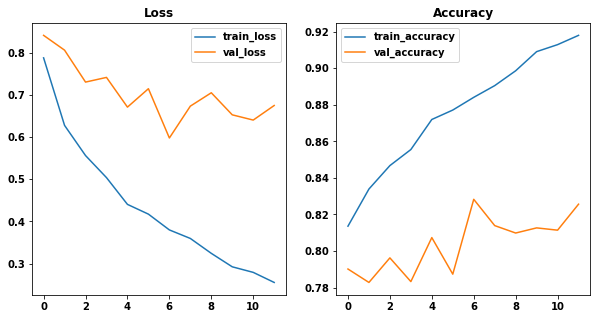

In [52]:
display_mode_trainTestGraphs(results)

In [53]:
results.model.save(tf_chkpt_path+'Model_4')

INFO:tensorflow:Assets written to: tf_checkpoints/Model_4\assets


INFO:tensorflow:Assets written to: tf_checkpoints/Model_4\assets


In terms of validation loss, best performing model so far. Increasing convolutions is definitely helping. Still very over fit

## Model 5a: Adding a dropout layer and furthering depth

To help reduce overfitting adding a dropout layer at dense layer level and increasing the number of convolutions before pooling

In [56]:
model = models.Sequential()

model.add(layers.Conv2D(filters=16,
                       kernel_size=3,
                       activation='relu',
                       input_shape=(227,227,1)))
model.add(layers.MaxPooling2D(2,2))

model.add(layers.Conv2D(32, 3, activation='relu'))
model.add(layers.MaxPooling2D(2,2))

model.add(layers.Conv2D(64, 3, activation='relu'))
model.add(layers.Conv2D(64, 3, activation='relu'))
model.add(layers.MaxPooling2D(2,2))

model.add(layers.Conv2D(128, 3, activation='relu'))
model.add(layers.Conv2D(128, 3, activation='relu'))
model.add(layers.MaxPooling2D(2,2))

model.add(layers.Flatten())
model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dropout(rate=0.2))
model.add(layers.Dense(8, activation='softmax'))


model.compile(optimizer=optimizers.Adam(learning_rate=0.001),
              loss=losses.CategoricalCrossentropy(),
              metrics=['accuracy', Precision(), Recall()])


model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_14 (Conv2D)          (None, 225, 225, 16)      160       
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 112, 112, 16)     0         
 g2D)                                                            
                                                                 
 conv2d_15 (Conv2D)          (None, 110, 110, 32)      4640      
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 55, 55, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_16 (Conv2D)          (None, 53, 53, 64)        18496     
                                                                 
 conv2d_17 (Conv2D)          (None, 51, 51, 64)       

In [57]:
results = model.fit(train_generator,
                    callbacks=early_stop,
                    steps_per_epoch=100,  # Number of training samples to pull per epoch
                    epochs=50,  # Number of epochs
                    validation_data=val_generator,
                    validation_steps=50,  # Number of validation samples to run validation on
                    verbose=1
                    )

Epoch 1/50
100/100 [==============================] - 14s 127ms/step - loss: 0.8472 - accuracy: 0.8070 - precision_5: 0.8140 - recall_5: 0.7927 - val_loss: 0.8458 - val_accuracy: 0.7966 - val_precision_5: 0.7966 - val_recall_5: 0.7966
Epoch 2/50
100/100 [==============================] - 13s 126ms/step - loss: 0.7507 - accuracy: 0.8198 - precision_5: 0.8277 - recall_5: 0.8109 - val_loss: 0.8364 - val_accuracy: 0.7866 - val_precision_5: 0.8001 - val_recall_5: 0.7575
Epoch 3/50
100/100 [==============================] - 13s 126ms/step - loss: 0.6719 - accuracy: 0.8252 - precision_5: 0.8492 - recall_5: 0.7970 - val_loss: 0.8169 - val_accuracy: 0.7923 - val_precision_5: 0.7980 - val_recall_5: 0.7788
Epoch 4/50
100/100 [==============================] - 13s 125ms/step - loss: 0.5656 - accuracy: 0.8445 - precision_5: 0.8637 - recall_5: 0.8252 - val_loss: 0.7741 - val_accuracy: 0.7862 - val_precision_5: 0.8082 - val_recall_5: 0.7627
Epoch 5/50
100/100 [==============================] - 13s 12

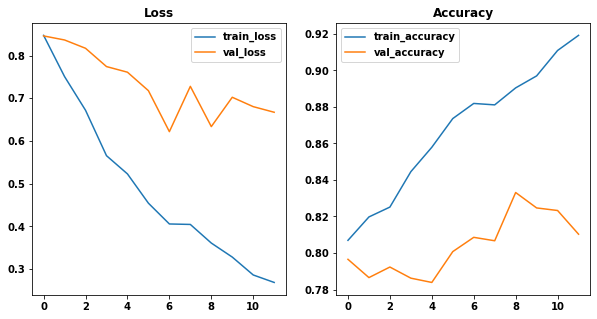

In [58]:
display_mode_trainTestGraphs(results)

In [59]:
results.model.save(tf_chkpt_path+'Model_5_Dropout_02')

INFO:tensorflow:Assets written to: tf_checkpoints/Model_5_Dropout_02\assets


INFO:tensorflow:Assets written to: tf_checkpoints/Model_5_Dropout_02\assets


## Model 5b: Adding a dropout layer and furthering depth

In [60]:
# Increasing dropout rate
model = models.Sequential()

model.add(layers.Conv2D(filters=16,
                       kernel_size=(3,3),
                       activation='relu',
                       input_shape=(227,227,1)))
model.add(layers.MaxPooling2D(2,2))

model.add(layers.Conv2D(32, (3,3), activation='relu'))
model.add(layers.MaxPooling2D(2,2))

model.add(layers.Conv2D(64, (3,3), activation='relu'))
model.add(layers.Conv2D(64, (3,3), activation='relu'))
model.add(layers.MaxPooling2D(2,2))

model.add(layers.Conv2D(128, (3,3), activation='relu'))
model.add(layers.Conv2D(128, (3,3), activation='relu'))
model.add(layers.MaxPooling2D(2,2))

model.add(layers.Flatten())
model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dropout(rate=0.5))
model.add(layers.Dense(8, activation='softmax'))


model.compile(optimizer=optimizers.Adam(learning_rate=0.001),
              loss=losses.CategoricalCrossentropy(),
              metrics=['accuracy', Precision(), Recall()])

model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_20 (Conv2D)          (None, 225, 225, 16)      160       
                                                                 
 max_pooling2d_18 (MaxPoolin  (None, 112, 112, 16)     0         
 g2D)                                                            
                                                                 
 conv2d_21 (Conv2D)          (None, 110, 110, 32)      4640      
                                                                 
 max_pooling2d_19 (MaxPoolin  (None, 55, 55, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_22 (Conv2D)          (None, 53, 53, 64)        18496     
                                                                 
 conv2d_23 (Conv2D)          (None, 51, 51, 64)       

In [61]:
results = model.fit(train_generator,
                    steps_per_epoch=100,  # Number of training samples to pull per epoch
                    epochs=50,  # Number of epochs
                    validation_data=val_generator,
                    validation_steps=50,  # Number of validation samples to run validation on
                    verbose=1,
                    callbacks = [early_stop]
                    )

Epoch 1/50
100/100 [==============================] - 13s 125ms/step - loss: 0.8465 - accuracy: 0.8111 - precision_6: 0.8189 - recall_6: 0.7855 - val_loss: 0.8581 - val_accuracy: 0.7945 - val_precision_6: 0.7945 - val_recall_6: 0.7945
Epoch 2/50
100/100 [==============================] - 12s 122ms/step - loss: 0.7818 - accuracy: 0.8204 - precision_6: 0.8204 - recall_6: 0.8202 - val_loss: 0.9089 - val_accuracy: 0.7908 - val_precision_6: 0.7908 - val_recall_6: 0.7908
Epoch 3/50
100/100 [==============================] - 12s 122ms/step - loss: 0.7531 - accuracy: 0.8168 - precision_6: 0.8190 - recall_6: 0.8150 - val_loss: 0.8657 - val_accuracy: 0.7958 - val_precision_6: 0.7968 - val_recall_6: 0.7861
Epoch 4/50
100/100 [==============================] - 12s 124ms/step - loss: 0.6611 - accuracy: 0.8239 - precision_6: 0.8501 - recall_6: 0.8015 - val_loss: 0.7704 - val_accuracy: 0.7912 - val_precision_6: 0.8136 - val_recall_6: 0.7569
Epoch 5/50
100/100 [==============================] - 12s 12

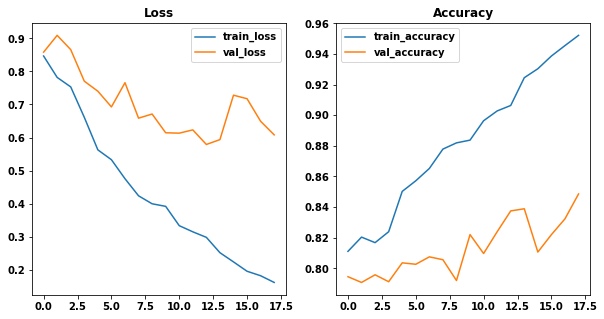

In [62]:
display_mode_trainTestGraphs(results)

In [63]:
results.model.save(tf_chkpt_path+'Model_5_Dropout_05')

INFO:tensorflow:Assets written to: tf_checkpoints/Model_5_Dropout_05\assets


INFO:tensorflow:Assets written to: tf_checkpoints/Model_5_Dropout_05\assets


The higher level of dropout has made a pretty discernable improvement in our validation loss. After epoch 13, loss started to increase again.

Still with a validation loss of about 0.58, the model at epoch 13 is our best performing model yet.

## Even deeeeeper NN

Trying to mimic VGG 16 architecture

In [67]:
model = models.Sequential()

model.add(layers.Conv2D(filters=16,
                       kernel_size=3,
                       activation='relu',
                       input_shape=(227,227,1)))
model.add(layers.MaxPooling2D(2,2))

model.add(layers.Conv2D(64, 3, activation='relu'))
model.add(layers.Conv2D(64, 3, activation='relu'))
model.add(layers.MaxPooling2D(2,2))

model.add(layers.Conv2D(128, 3, activation='relu'))
model.add(layers.Conv2D(128, 3, activation='relu'))
model.add(layers.MaxPooling2D(2,2))

model.add(layers.Conv2D(256, 3, activation='relu'))
model.add(layers.Conv2D(256, 3, activation='relu'))
model.add(layers.Conv2D(256, 3, activation='relu'))
model.add(layers.MaxPooling2D(2,2))

model.add(layers.Flatten())
model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dense(1024, activation='relu'))
# model.add(layers.Dropout(rate=0.5))
model.add(layers.Dense(8, activation='softmax'))

model.compile(optimizer=optimizers.Adam(learning_rate=0.001),
              loss=losses.CategoricalCrossentropy(),
              metrics=['accuracy', Precision(), Recall()])

model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_42 (Conv2D)          (None, 225, 225, 16)      160       
                                                                 
 max_pooling2d_30 (MaxPoolin  (None, 112, 112, 16)     0         
 g2D)                                                            
                                                                 
 conv2d_43 (Conv2D)          (None, 110, 110, 64)      9280      
                                                                 
 conv2d_44 (Conv2D)          (None, 108, 108, 64)      36928     
                                                                 
 max_pooling2d_31 (MaxPoolin  (None, 54, 54, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_45 (Conv2D)          (None, 52, 52, 128)      

In [68]:
results = model.fit(train_generator,
                    steps_per_epoch=100,  # Number of training samples to pull per epoch
                    epochs=50,  # Number of epochs
                    validation_data=val_generator,
                    validation_steps=50,  # Number of validation samples to run validation on
                    verbose=1,
                    callbacks = [early_stop]
                    )

Epoch 1/50
100/100 [==============================] - 28s 243ms/step - loss: 1.0280 - accuracy: 0.7994 - precision_9: 0.8125 - recall_9: 0.7382 - val_loss: 0.8826 - val_accuracy: 0.7983 - val_precision_9: 0.7983 - val_recall_9: 0.7983
Epoch 2/50
100/100 [==============================] - 24s 242ms/step - loss: 0.7901 - accuracy: 0.8177 - precision_9: 0.8177 - recall_9: 0.8177 - val_loss: 0.8676 - val_accuracy: 0.7881 - val_precision_9: 0.7881 - val_recall_9: 0.7881
Epoch 3/50
100/100 [==============================] - 26s 261ms/step - loss: 0.7852 - accuracy: 0.8175 - precision_9: 0.8175 - recall_9: 0.8175 - val_loss: 0.8449 - val_accuracy: 0.7997 - val_precision_9: 0.7997 - val_recall_9: 0.7997
Epoch 4/50
100/100 [==============================] - 24s 240ms/step - loss: 0.7867 - accuracy: 0.8183 - precision_9: 0.8183 - recall_9: 0.8183 - val_loss: 0.8925 - val_accuracy: 0.7847 - val_precision_9: 0.7847 - val_recall_9: 0.7847
Epoch 5/50
100/100 [==============================] - 24s 24

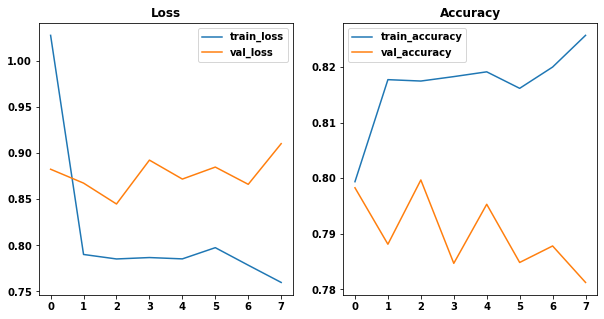

In [69]:
display_mode_trainTestGraphs(results)

In [70]:
results.model.save(tf_chkpt_path+'Model_6_VGG_prototype')

INFO:tensorflow:Assets written to: tf_checkpoints/Model_6_VGG_prototype\assets


INFO:tensorflow:Assets written to: tf_checkpoints/Model_6_VGG_prototype\assets


Severe overfitting with no discernable improvement in validaiton losses or accuracy

In [71]:
# with dropout
model = models.Sequential()

model.add(layers.Conv2D(filters=16,
                       kernel_size=3,
                       activation='relu',
                       input_shape=(227,227,1)))
model.add(layers.MaxPooling2D(2,2))

model.add(layers.Conv2D(64, 3, activation='relu'))
model.add(layers.Conv2D(64, 3, activation='relu'))
model.add(layers.MaxPooling2D(2,2))

model.add(layers.Conv2D(128, 3, activation='relu'))
model.add(layers.Conv2D(128, 3, activation='relu'))
model.add(layers.MaxPooling2D(2,2))

model.add(layers.Conv2D(256, 3, activation='relu'))
model.add(layers.Conv2D(256, 3, activation='relu'))
model.add(layers.Conv2D(256, 3, activation='relu'))
model.add(layers.MaxPooling2D(2,2))

model.add(layers.Flatten())
model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dropout(rate=0.5))
model.add(layers.Dense(8, activation='softmax'))

model.compile(optimizer=optimizers.Adam(learning_rate=0.001),
              loss=losses.CategoricalCrossentropy(),
              metrics=['accuracy', Precision(), Recall()])

model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_50 (Conv2D)          (None, 225, 225, 16)      160       
                                                                 
 max_pooling2d_34 (MaxPoolin  (None, 112, 112, 16)     0         
 g2D)                                                            
                                                                 
 conv2d_51 (Conv2D)          (None, 110, 110, 64)      9280      
                                                                 
 conv2d_52 (Conv2D)          (None, 108, 108, 64)      36928     
                                                                 
 max_pooling2d_35 (MaxPoolin  (None, 54, 54, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_53 (Conv2D)          (None, 52, 52, 128)     

In [72]:
results = model.fit(train_generator,
                    steps_per_epoch=100,  # Number of training samples to pull per epoch
                    epochs=50,  # Number of epochs
                    validation_data=val_generator,
                    validation_steps=50,  # Number of validation samples to run validation on
                    verbose=1,
                    callbacks = [early_stop]
                    )

Epoch 1/50
100/100 [==============================] - 25s 241ms/step - loss: 1.0010 - accuracy: 0.7957 - precision_10: 0.8215 - recall_10: 0.7461 - val_loss: 0.8967 - val_accuracy: 0.7848 - val_precision_10: 0.7848 - val_recall_10: 0.7848
Epoch 2/50
100/100 [==============================] - 24s 240ms/step - loss: 0.8051 - accuracy: 0.8148 - precision_10: 0.8148 - recall_10: 0.8148 - val_loss: 0.9083 - val_accuracy: 0.7814 - val_precision_10: 0.7814 - val_recall_10: 0.7814
Epoch 3/50
100/100 [==============================] - 24s 241ms/step - loss: 0.7856 - accuracy: 0.8211 - precision_10: 0.8211 - recall_10: 0.8211 - val_loss: 0.8393 - val_accuracy: 0.8000 - val_precision_10: 0.8000 - val_recall_10: 0.8000
Epoch 4/50
100/100 [==============================] - 24s 240ms/step - loss: 0.7877 - accuracy: 0.8158 - precision_10: 0.8254 - recall_10: 0.8023 - val_loss: 0.8446 - val_accuracy: 0.7925 - val_precision_10: 0.8107 - val_recall_10: 0.7267
Epoch 5/50
100/100 [========================

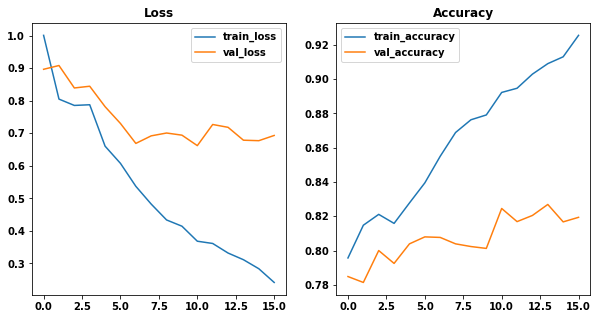

In [73]:
display_mode_trainTestGraphs(results)

In [74]:
results.model.save(tf_chkpt_path+'Model_6_VGG_w_dropout')

INFO:tensorflow:Assets written to: tf_checkpoints/Model_6_VGG_w_dropout\assets


INFO:tensorflow:Assets written to: tf_checkpoints/Model_6_VGG_w_dropout\assets


Dropout clearly is making a difference.

## Model 7: Reducing conv layers per set

In [75]:
model = models.Sequential()

model.add(layers.Conv2D(filters=16,
                       kernel_size=3,
                       activation='relu',
                       input_shape=(227,227,1)))
model.add(layers.MaxPooling2D(2,2))

model.add(layers.Conv2D(64, 3, activation='relu'))
model.add(layers.MaxPooling2D(2,2))

model.add(layers.Conv2D(128, 3, activation='relu'))
model.add(layers.MaxPooling2D(2,2))

model.add(layers.Conv2D(256, 3, activation='relu'))
model.add(layers.MaxPooling2D(2,2))

model.add(layers.Conv2D(512, 3, activation='relu'))
model.add(layers.MaxPooling2D(2,2))

model.add(layers.Flatten())
model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dropout(rate=0.5))
model.add(layers.Dense(8, activation='softmax'))


model.compile(optimizer=optimizers.Adam(learning_rate=0.001),
              loss=losses.CategoricalCrossentropy(),
              metrics=['accuracy', Precision(), Recall()])


model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_58 (Conv2D)          (None, 225, 225, 16)      160       
                                                                 
 max_pooling2d_38 (MaxPoolin  (None, 112, 112, 16)     0         
 g2D)                                                            
                                                                 
 conv2d_59 (Conv2D)          (None, 110, 110, 64)      9280      
                                                                 
 max_pooling2d_39 (MaxPoolin  (None, 55, 55, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_60 (Conv2D)          (None, 53, 53, 128)       73856     
                                                                 
 max_pooling2d_40 (MaxPoolin  (None, 26, 26, 128)    

In [76]:
results = model.fit(train_generator,
                    steps_per_epoch=100,  # Number of training samples to pull per epoch
                    epochs=50,  # Number of epochs
                    validation_data=val_generator,
                    validation_steps=50,  # Number of validation samples to run validation on
                    verbose=1,
                    callbacks = [early_stop]
                    )

Epoch 1/50
100/100 [==============================] - 17s 150ms/step - loss: 0.9004 - accuracy: 0.8116 - precision_11: 0.8193 - recall_11: 0.7576 - val_loss: 0.8608 - val_accuracy: 0.7912 - val_precision_11: 0.7912 - val_recall_11: 0.7912
Epoch 2/50
100/100 [==============================] - 15s 146ms/step - loss: 0.7725 - accuracy: 0.8155 - precision_11: 0.8257 - recall_11: 0.7984 - val_loss: 0.9407 - val_accuracy: 0.7655 - val_precision_11: 0.7865 - val_recall_11: 0.6452
Epoch 3/50
100/100 [==============================] - 15s 150ms/step - loss: 0.6695 - accuracy: 0.8319 - precision_11: 0.8561 - recall_11: 0.8025 - val_loss: 0.8361 - val_accuracy: 0.7952 - val_precision_11: 0.8028 - val_recall_11: 0.7912
Epoch 4/50
100/100 [==============================] - 15s 149ms/step - loss: 0.5923 - accuracy: 0.8403 - precision_11: 0.8728 - recall_11: 0.8077 - val_loss: 0.7797 - val_accuracy: 0.7861 - val_precision_11: 0.8217 - val_recall_11: 0.7186
Epoch 5/50
100/100 [========================

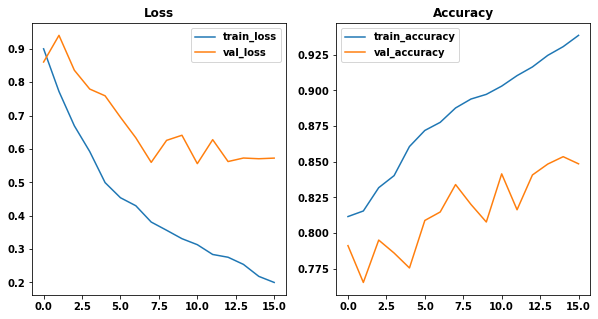

In [77]:
display_mode_trainTestGraphs(results)

In [79]:
results.model.save(tf_chkpt_path+'Model_7a_VGG_1convPer')

INFO:tensorflow:Assets written to: tf_checkpoints/Model_7a_VGG_1convPer\assets


INFO:tensorflow:Assets written to: tf_checkpoints/Model_7a_VGG_1convPer\assets


Validation loss further reduced, with the lowest recorded 0.5598. And more importantly its holding and not drastically increasing again again.

### Reducing learning rate

Going to rerun the previous model, but reducing learning rate. Intuition being a more granular descent might help with the erratic validation scores.

In [80]:
model = models.Sequential()

model.add(layers.Conv2D(filters=16,
                       kernel_size=3,
                       activation='relu',
                       input_shape=(227,227,1)))
model.add(layers.MaxPooling2D(2,2))

model.add(layers.Conv2D(64, 3, activation='relu'))
model.add(layers.MaxPooling2D(2,2))

model.add(layers.Conv2D(128, 3, activation='relu'))
model.add(layers.MaxPooling2D(2,2))

model.add(layers.Conv2D(256, 3, activation='relu'))
model.add(layers.MaxPooling2D(2,2))

model.add(layers.Conv2D(512, 3, activation='relu'))
model.add(layers.MaxPooling2D(2,2))

model.add(layers.Flatten())
model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dropout(rate=0.5))
model.add(layers.Dense(8, activation='softmax'))


model.compile(optimizer=optimizers.Adam(learning_rate=0.0001),
              loss=losses.CategoricalCrossentropy(),
              metrics=['accuracy', Precision(), Recall()])


model.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_63 (Conv2D)          (None, 225, 225, 16)      160       
                                                                 
 max_pooling2d_43 (MaxPoolin  (None, 112, 112, 16)     0         
 g2D)                                                            
                                                                 
 conv2d_64 (Conv2D)          (None, 110, 110, 64)      9280      
                                                                 
 max_pooling2d_44 (MaxPoolin  (None, 55, 55, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_65 (Conv2D)          (None, 53, 53, 128)       73856     
                                                                 
 max_pooling2d_45 (MaxPoolin  (None, 26, 26, 128)    

In [81]:
results = model.fit(train_generator,
                    steps_per_epoch=100,  # Number of training samples to pull per epoch
                    epochs=50,  # Number of epochs
                    validation_data=val_generator,
                    validation_steps=100,  # Number of validation samples to run validation on
                    verbose=1,
                    callbacks = [early_stop]
                    )

Epoch 1/50
100/100 [==============================] - 20s 193ms/step - loss: 0.9116 - accuracy: 0.8122 - precision_12: 0.8215 - recall_12: 0.7389 - val_loss: 0.8565 - val_accuracy: 0.7924 - val_precision_12: 0.7924 - val_recall_12: 0.7924
Epoch 2/50
100/100 [==============================] - 19s 186ms/step - loss: 0.7372 - accuracy: 0.8205 - precision_12: 0.8287 - recall_12: 0.8114 - val_loss: 0.8373 - val_accuracy: 0.7916 - val_precision_12: 0.7985 - val_recall_12: 0.7807
Epoch 3/50
100/100 [==============================] - 19s 187ms/step - loss: 0.6729 - accuracy: 0.8255 - precision_12: 0.8506 - recall_12: 0.7995 - val_loss: 0.7921 - val_accuracy: 0.7886 - val_precision_12: 0.8054 - val_recall_12: 0.7577
Epoch 4/50
100/100 [==============================] - 19s 186ms/step - loss: 0.6214 - accuracy: 0.8302 - precision_12: 0.8598 - recall_12: 0.8012 - val_loss: 0.7789 - val_accuracy: 0.7792 - val_precision_12: 0.8112 - val_recall_12: 0.7545
Epoch 5/50
100/100 [========================

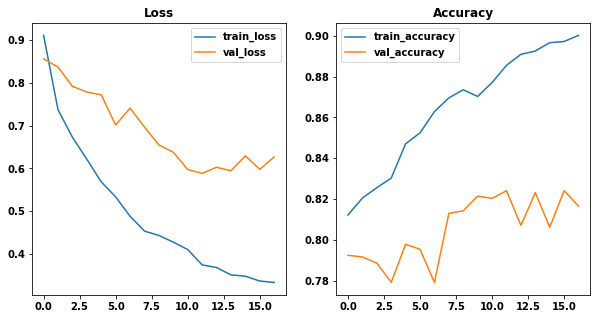

In [82]:
display_mode_trainTestGraphs(results)

In [83]:
results.model.save(tf_chkpt_path+'Model_7a_VGG_1convPer')

INFO:tensorflow:Assets written to: tf_checkpoints/Model_7a_VGG_1convPer\assets


INFO:tensorflow:Assets written to: tf_checkpoints/Model_7a_VGG_1convPer\assets


Learning rate didn't have the desired/expected outcome. Althought validation losses seem to have a smoother descent

### Increasing steps per epoch

Keeping the same reduced learning rate but increasing the number of training steps per epoch

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_68 (Conv2D)          (None, 225, 225, 16)      160       
                                                                 
 max_pooling2d_48 (MaxPoolin  (None, 112, 112, 16)     0         
 g2D)                                                            
                                                                 
 conv2d_69 (Conv2D)          (None, 110, 110, 64)      9280      
                                                                 
 max_pooling2d_49 (MaxPoolin  (None, 55, 55, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_70 (Conv2D)          (None, 53, 53, 128)       73856     
                                                                 
 max_pooling2d_50 (MaxPoolin  (None, 26, 26, 128)    

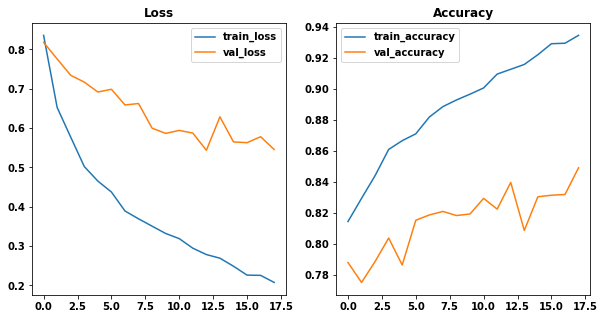

In [84]:
model = models.Sequential()

model.add(layers.Conv2D(filters=16,
                       kernel_size=(3,3),
                       activation='relu',
                       input_shape=(227,227,1)))
model.add(layers.MaxPooling2D(2,2))

model.add(layers.Conv2D(64, (3,3), activation='relu'))
model.add(layers.MaxPooling2D(2,2))

model.add(layers.Conv2D(128, (3,3), activation='relu'))
model.add(layers.MaxPooling2D(2,2))

model.add(layers.Conv2D(256, (3,3), activation='relu'))
model.add(layers.MaxPooling2D(2,2))

model.add(layers.Conv2D(512, (3,3), activation='relu'))
model.add(layers.MaxPooling2D(2,2))

model.add(layers.Flatten())
model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dropout(rate=0.5))
model.add(layers.Dense(8, activation='softmax'))


model.compile(optimizer=optimizers.Adam(learning_rate=0.0001),
              loss=losses.CategoricalCrossentropy(),
              metrics=['accuracy', Precision(), Recall()])

model.summary()

results = model.fit(train_generator,
                    steps_per_epoch=200,  # Number of training samples to pull per epoch
                    epochs=50,  # Number of epochs
                    validation_data=val_generator,
                    validation_steps=100,  # Number of validation samples to run validation on
                    verbose=1,
                    callbacks = [early_stop]
                    )


display_mode_trainTestGraphs(results)

Increasing the number of training samples has had a positive impact. More training examples per epoch makes for a more informed update on the weights. Overall validation loss has shown a smoother descent but also maintains around 0.55.

Lowest recorded val_loss of 0.5434

## Model 8 - Adding 1 additional convolution at a time

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_73 (Conv2D)          (None, 225, 225, 16)      160       
                                                                 
 max_pooling2d_53 (MaxPoolin  (None, 112, 112, 16)     0         
 g2D)                                                            
                                                                 
 conv2d_74 (Conv2D)          (None, 110, 110, 64)      9280      
                                                                 
 max_pooling2d_54 (MaxPoolin  (None, 55, 55, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_75 (Conv2D)          (None, 53, 53, 128)       73856     
                                                                 
 max_pooling2d_55 (MaxPoolin  (None, 26, 26, 128)    

200/200 [==============================] - 32s 158ms/step - loss: 0.1126 - accuracy: 0.9617 - precision_14: 0.9637 - recall_14: 0.9595 - val_loss: 0.5154 - val_accuracy: 0.8694 - val_precision_14: 0.8727 - val_recall_14: 0.8657
Epoch 24/50
200/200 [==============================] - 32s 159ms/step - loss: 0.1090 - accuracy: 0.9654 - precision_14: 0.9675 - recall_14: 0.9635 - val_loss: 0.5042 - val_accuracy: 0.8645 - val_precision_14: 0.8722 - val_recall_14: 0.8597
Epoch 24: early stopping


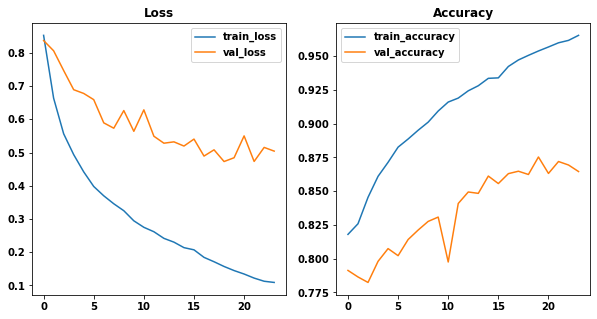

In [85]:
# one additional convolution at 512 layer
model = models.Sequential()

model.add(layers.Conv2D(filters=16,
                       kernel_size=3,
                       activation='relu',
                       input_shape=(227,227,1)))
model.add(layers.MaxPooling2D(2,2))

model.add(layers.Conv2D(64, 3, activation='relu'))
model.add(layers.MaxPooling2D(2,2))

model.add(layers.Conv2D(128, 3, activation='relu'))
model.add(layers.MaxPooling2D(2,2))

model.add(layers.Conv2D(256, 3, activation='relu'))
model.add(layers.MaxPooling2D(2,2))

model.add(layers.Conv2D(512, 3, activation='relu'))
model.add(layers.Conv2D(512, 3, activation='relu'))
model.add(layers.MaxPooling2D(2,2))

model.add(layers.Flatten())
model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dropout(rate=0.5))
model.add(layers.Dense(8, activation='softmax'))


model.compile(optimizer=optimizers.Adam(learning_rate=0.0001),
              loss=losses.CategoricalCrossentropy(),
              metrics=['accuracy', Precision(), Recall()])

model.summary()

results = model.fit(train_generator,
                    steps_per_epoch=200,  # Number of training samples to pull per epoch
                    epochs=50,  # Number of epochs
                    validation_data=val_generator,
                    validation_steps=100,  # Number of validation samples to run validation on
                    verbose=1,
                    callbacks = [early_stop]
                    )

display_mode_trainTestGraphs(results)

In [ ]:
results.model.save(tf_chkpt_path+'Model_8')

Best performing model yet. Val loss was hovering around 0.5

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_92 (Conv2D)          (None, 225, 225, 16)      160       
                                                                 
 max_pooling2d_68 (MaxPoolin  (None, 112, 112, 16)     0         
 g2D)                                                            
                                                                 
 conv2d_93 (Conv2D)          (None, 110, 110, 64)      9280      
                                                                 
 max_pooling2d_69 (MaxPoolin  (None, 55, 55, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_94 (Conv2D)          (None, 53, 53, 128)       73856     
                                                                 
 max_pooling2d_70 (MaxPoolin  (None, 26, 26, 128)    

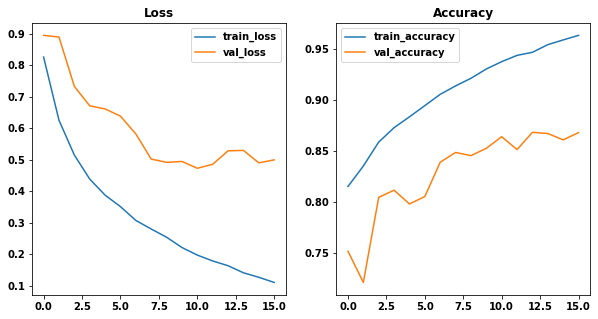

In [88]:
# one additional convolution at 512, 256 layer
model = models.Sequential()

model.add(layers.Conv2D(filters=16,
                       kernel_size=3,
                       activation='relu',
                       input_shape=(227,227,1)))
model.add(layers.MaxPooling2D(2,2))

model.add(layers.Conv2D(64, 3, activation='relu'))
model.add(layers.MaxPooling2D(2,2))

model.add(layers.Conv2D(128, 3, activation='relu'))
model.add(layers.MaxPooling2D(2,2))

model.add(layers.Conv2D(256, 3, activation='relu'))
model.add(layers.Conv2D(256, 3, activation='relu'))
model.add(layers.MaxPooling2D(2,2))

model.add(layers.Conv2D(512, 3, activation='relu'))
model.add(layers.Conv2D(512, 3, activation='relu'))
model.add(layers.MaxPooling2D(2,2))

model.add(layers.Flatten())
model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dropout(rate=0.5))
model.add(layers.Dense(8, activation='softmax'))


model.compile(optimizer=optimizers.Adam(learning_rate=0.0001),
              loss=losses.CategoricalCrossentropy(),
              metrics=['accuracy', Precision(), Recall()])

model.summary()

results = model.fit(train_generator,
                    steps_per_epoch=300,  # Number of training samples to pull per epoch
                    epochs=50,  # Number of epochs
                    validation_data=val_generator,
                    validation_steps=100,  # Number of validation samples to run validation on
                    verbose=1,
                    callbacks = [early_stop]
                    )

display_mode_trainTestGraphs(results)

In [89]:
results.model.save(tf_chkpt_path+'Model_8')

INFO:tensorflow:Assets written to: tf_checkpoints/Model_8\assets


INFO:tensorflow:Assets written to: tf_checkpoints/Model_8\assets


## Model 9

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_106 (Conv2D)         (None, 225, 225, 16)      160       
                                                                 
 max_pooling2d_78 (MaxPoolin  (None, 112, 112, 16)     0         
 g2D)                                                            
                                                                 
 conv2d_107 (Conv2D)         (None, 110, 110, 64)      9280      
                                                                 
 max_pooling2d_79 (MaxPoolin  (None, 55, 55, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_108 (Conv2D)         (None, 53, 53, 128)       73856     
                                                                 
 max_pooling2d_80 (MaxPoolin  (None, 26, 26, 128)    

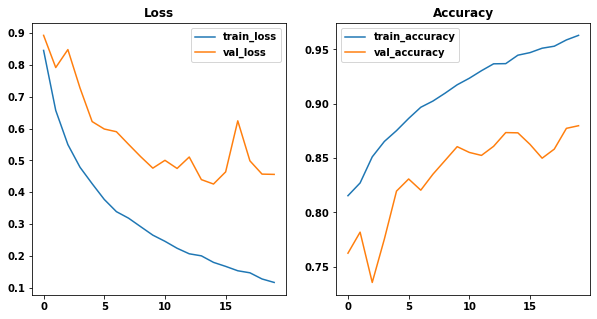

In [91]:
model = models.Sequential()

model.add(layers.Conv2D(filters=16,
                       kernel_size=3,
                       activation='relu',
                       input_shape=(227,227,1)))
model.add(layers.MaxPooling2D(2,2))

model.add(layers.Conv2D(64, 3, activation='relu'))
model.add(layers.MaxPooling2D(2,2))

model.add(layers.Conv2D(128, 3, activation='relu'))
model.add(layers.MaxPooling2D(2,2))

model.add(layers.Conv2D(256, 3, activation='relu'))
model.add(layers.Conv2D(256, 3, activation='relu'))
model.add(layers.MaxPooling2D(2,2))

model.add(layers.Conv2D(512, 3, activation='relu'))
model.add(layers.Conv2D(512, 3, activation='relu'))
model.add(layers.MaxPooling2D(2,2))

model.add(layers.Dropout(rate=0.3))

model.add(layers.Flatten())
model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dropout(rate=0.5))
model.add(layers.Dense(8, activation='softmax'))


model.compile(optimizer=optimizers.Adam(learning_rate=0.0001),
              loss=losses.CategoricalCrossentropy(),
              metrics=['accuracy', Precision(), Recall()])

model.summary()

results = model.fit(train_generator,
                    steps_per_epoch=250,  # Number of training samples to pull per epoch
                    epochs=50,  # Number of epochs
                    validation_data=val_generator,
                    validation_steps=100,  # Number of validation samples to run validation on
                    verbose=1,
                    callbacks = [early_stop]
                    )

display_mode_trainTestGraphs(results)

In [92]:
results.model.save(tf_chkpt_path+'Model_9')

INFO:tensorflow:Assets written to: tf_checkpoints/Model_9\assets


INFO:tensorflow:Assets written to: tf_checkpoints/Model_9\assets


Best numbers yet. Val_loss of 0.42

## Model 10

Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_113 (Conv2D)         (None, 225, 225, 16)      160       
                                                                 
 max_pooling2d_83 (MaxPoolin  (None, 112, 112, 16)     0         
 g2D)                                                            
                                                                 
 conv2d_114 (Conv2D)         (None, 110, 110, 64)      9280      
                                                                 
 max_pooling2d_84 (MaxPoolin  (None, 55, 55, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_115 (Conv2D)         (None, 53, 53, 128)       73856     
                                                                 
 conv2d_116 (Conv2D)         (None, 51, 51, 128)     

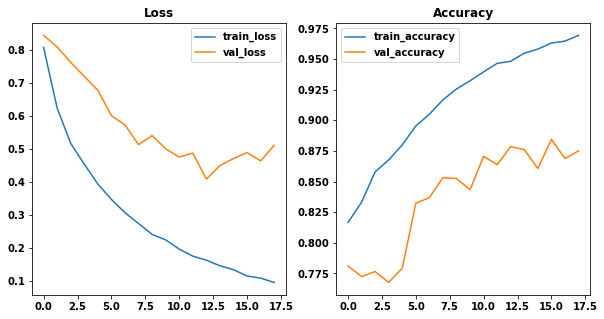

In [94]:
model = models.Sequential()

model.add(layers.Conv2D(filters=16,
                       kernel_size=3,
                       activation='relu',
                       input_shape=(227,227,1)))
model.add(layers.MaxPooling2D(2,2))

model.add(layers.Conv2D(64, 3, activation='relu'))
model.add(layers.MaxPooling2D(2,2))

model.add(layers.Conv2D(128, 3, activation='relu'))
model.add(layers.Conv2D(128, 3, activation='relu'))
model.add(layers.MaxPooling2D(2,2))

model.add(layers.Conv2D(256, 3, activation='relu'))
model.add(layers.Conv2D(256, 3, activation='relu'))
model.add(layers.MaxPooling2D(2,2))

model.add(layers.Conv2D(512, 3, activation='relu'))
model.add(layers.Conv2D(512, 3, activation='relu'))
model.add(layers.MaxPooling2D(2,2))

model.add(layers.Dropout(rate=0.5))

model.add(layers.Flatten())
model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dropout(rate=0.5))

model.add(layers.Dense(8, activation='softmax'))


model.compile(optimizer=optimizers.Adam(learning_rate=0.0001),
              loss=losses.CategoricalCrossentropy(),
              metrics=['accuracy', Precision(), Recall()])

model.summary()

results = model.fit(train_generator,
                    steps_per_epoch=300,  # Number of training samples to pull per epoch
                    epochs=50,  # Number of epochs
                    validation_data=val_generator,
                    validation_steps=100,  # Number of validation samples to run validation on
                    verbose=1,
                    callbacks = [early_stop]
                    )

display_mode_trainTestGraphs(results)

In [95]:
results.model.save(tf_chkpt_path+'Model_10')

INFO:tensorflow:Assets written to: tf_checkpoints/Model_10\assets


INFO:tensorflow:Assets written to: tf_checkpoints/Model_10\assets


Best numbers yet. Val_loss of 0.40

## Model 11

Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_139 (Conv2D)         (None, 225, 225, 16)      160       
                                                                 
 max_pooling2d_98 (MaxPoolin  (None, 112, 112, 16)     0         
 g2D)                                                            
                                                                 
 conv2d_140 (Conv2D)         (None, 110, 110, 64)      9280      
                                                                 
 max_pooling2d_99 (MaxPoolin  (None, 55, 55, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_141 (Conv2D)         (None, 53, 53, 128)       73856     
                                                                 
 conv2d_142 (Conv2D)         (None, 51, 51, 128)     

300/300 [==============================] - 55s 183ms/step - loss: 0.7224 - accuracy: 0.8167 - precision_23: 0.8370 - recall_23: 0.8041 - val_loss: 0.8360 - val_accuracy: 0.7929 - val_precision_23: 0.7944 - val_recall_23: 0.7610
Epoch 21/50
300/300 [==============================] - 55s 182ms/step - loss: 0.7121 - accuracy: 0.8187 - precision_23: 0.8417 - recall_23: 0.8052 - val_loss: 0.8512 - val_accuracy: 0.7924 - val_precision_23: 0.8037 - val_recall_23: 0.7185
Epoch 22/50
300/300 [==============================] - 55s 183ms/step - loss: 0.7063 - accuracy: 0.8186 - precision_23: 0.8461 - recall_23: 0.8029 - val_loss: 0.8412 - val_accuracy: 0.7902 - val_precision_23: 0.7974 - val_recall_23: 0.7437
Epoch 23/50
300/300 [==============================] - 55s 182ms/step - loss: 0.6985 - accuracy: 0.8181 - precision_23: 0.8510 - recall_23: 0.7992 - val_loss: 0.8376 - val_accuracy: 0.7872 - val_precision_23: 0.8021 - val_recall_23: 0.7391
Epoch 23: early stopping


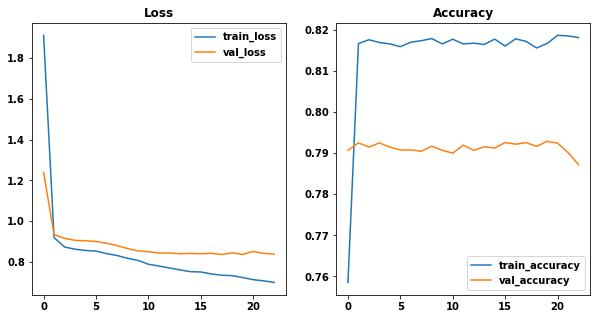

In [99]:
model = models.Sequential()

model.add(layers.Conv2D(filters=16,
                       kernel_size=3,
                       activation='relu',
                       input_shape=(227,227,1)))
model.add(layers.MaxPooling2D(2,2))

model.add(layers.Conv2D(64, 3, activation='relu'))
model.add(layers.MaxPooling2D(2,2))

model.add(layers.Conv2D(128, 3, activation='relu'))
model.add(layers.Conv2D(128, 3, activation='relu'))
model.add(layers.MaxPooling2D(2,2))

model.add(layers.Conv2D(256, 3, activation='relu'))
model.add(layers.Conv2D(256, 3, activation='relu'))
model.add(layers.MaxPooling2D(2,2))

model.add(layers.Conv2D(512, 3, activation='relu'))
model.add(layers.Conv2D(512, 3, activation='relu'))
model.add(layers.Conv2D(512, 3, activation='relu'))
model.add(layers.MaxPooling2D(2,2))

model.add(layers.Dropout(rate=0.5))

model.add(layers.Flatten())
model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dropout(rate=0.5))

model.add(layers.Dense(8, activation='softmax'))


model.compile(optimizer=optimizers.Adam(learning_rate=1e-6),
              loss=losses.CategoricalCrossentropy(),
              metrics=['accuracy', Precision(), Recall()])

model.summary()

results = model.fit(train_generator,
                    steps_per_epoch=300,  # Number of training samples to pull per epoch
                    epochs=50,  # Number of epochs
                    validation_data=val_generator,
                    validation_steps=100,  # Number of validation samples to run validation on
                    verbose=1,
                    callbacks = [early_stop]
                    )

display_mode_trainTestGraphs(results)

In [100]:
results.model.save(tf_chkpt_path+'Model_11')

INFO:tensorflow:Assets written to: tf_checkpoints/Model_11\assets


INFO:tensorflow:Assets written to: tf_checkpoints/Model_11\assets
